In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

* The datasets we are gonna use now are M2 Stock Exchange & Personal Consumption from FRED
  * M2 Stock Exchange include
    * Savings Deposits
    * small-denomination time desposits
    * balance in retail money market mutual funds.
  * Personal Consumption is the money used for daily needs
* The main link b/w two datasets are if a person have less money with him the spending expenditure will gradually reduce; whereas if a person have more money the personal expenditure will increase.
* k=2 as we have two different datasets.
* Pyramid auto_arima won't be useful for VAR in finding the optimal p-value
* We run a various p-values through a loop to find the best AIC value.
* We are using AIC as our criterion.
* Recall AIC will also punish model for being too complex, even if they perform slightly better on some other metric.
* We expect a drop in AIC as p gets larger and then at a certain point (lag order p value) an increasing AIC.
* We also need to check manually for stationarity and difference of time series if they aren't stationary.

In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving M2SLMoneyStock.csv to M2SLMoneyStock (1).csv
Saving PCEPersonalSpending.csv to PCEPersonalSpending (1).csv


In [4]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df1 = pd.read_csv('/content/M2SLMoneyStock.csv', index_col=0, parse_dates=True)
df1.index.freq = 'MS'
df2 = pd.read_csv('/content/PCEPersonalSpending.csv', index_col=0, parse_dates=True)
df2.index.freq = 'MS'

In [7]:
df1.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [8]:
df2.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [9]:
df = df1.join(df2)

In [10]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [11]:
df.shape

(252, 2)

In [12]:
df.isnull().sum()

Money       0
Spending    0
dtype: int64

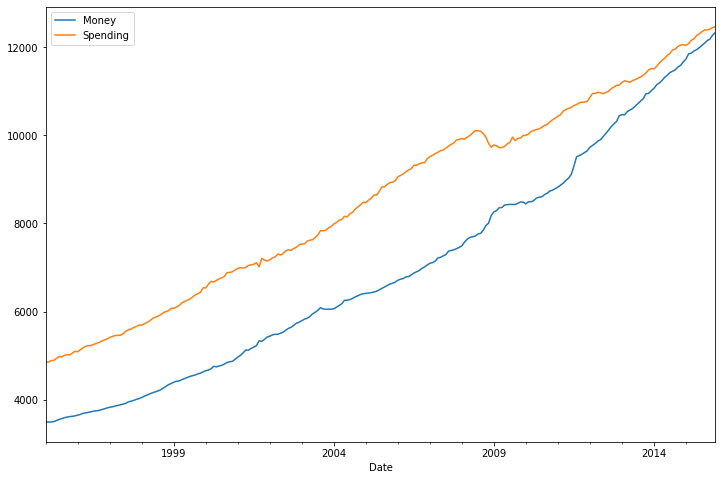

In [13]:
df.plot(figsize = (12,8))

## Checking Stationarity


In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [15]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [16]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


* As the data provided is non-stationary we need to convert the data in to stationary!

In [17]:
df_transformed = df.diff()
df_transformed

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9
...,...,...
2015-08-01,51.5,38.6
2015-09-01,57.0,-1.2
2015-10-01,33.9,23.3


In [18]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [19]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
print("df_transfomed['Money'] : ", df_transformed['Money'].head())
print('-*20')
print("df_transfomed['Spending'] : ", df_transformed['Spending'].head())

df_transfomed['Money'] :  Date
1995-01-01     NaN
1995-02-01    -2.5
1995-03-01     1.2
1995-04-01     8.1
1995-05-01    25.0
Freq: MS, Name: Money, dtype: float64
-*20
df_transfomed['Spending'] :  Date
1995-01-01     NaN
1995-02-01    -0.4
1995-03-01    34.6
1995-04-01     4.8
1995-05-01    42.9
Freq: MS, Name: Spending, dtype: float64


* The transformed dataset is showing some amount of non-stationarity for the 'MONEY' column, so we need to re-transform the transformed column.
* For every time we transform the data we will loose one column in the data as Nan column.
* The above transformed data have one stationary data & one non stationary data, so we need to transform the whole data again, but not only the non stationary column. Because transforming everytime will loose once column, if we do transform only one column there will be imbalances in the new transformed data(re-transformed) and transformed data. So, we need to transform whole data again.

In [21]:
df_transformed = df_transformed.diff()

In [22]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [23]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [24]:
print("df_transfomed['Money'] : ", df_transformed['Money'].head())
print()
print("df_transfomed['Spending'] : ", df_transformed['Spending'].head())

df_transfomed['Money'] :  Date
1995-01-01     NaN
1995-02-01     NaN
1995-03-01     3.7
1995-04-01     6.9
1995-05-01    16.9
Freq: MS, Name: Money, dtype: float64

df_transfomed['Spending'] :  Date
1995-01-01     NaN
1995-02-01     NaN
1995-03-01    35.0
1995-04-01   -29.8
1995-05-01    38.1
Freq: MS, Name: Spending, dtype: float64


* The re-transformed data have seen an increase in the null values compared to first transformation.
* The Nan values should be deleted now.

In [25]:
df_transformed = df_transformed.dropna()

In [26]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [27]:
df_transformed.shape

(250, 2)

## Splitting the data in to Train & Test

In [28]:
n_observations = 12

In [29]:
train = df_transformed[:-n_observations]
test = df_transformed[-n_observations:]

## Grid Search For Order 'p' AR(Auto Regression) of VAR model

In [30]:
model = VAR(train)

for p in [1,2,3,4,5,6,7]: # for p in range(8)
  results = model.fit(p)
  print(f'Order{p}')
  print(f'AIC:{results.aic}')
  print('\n')

Order1
AIC:14.178610495220896


Order2
AIC:13.955189367163705


Order3
AIC:13.849518291541038


Order4
AIC:13.827950574458281


Order5
AIC:13.78730034460964


Order6
AIC:13.799076756885809


Order7
AIC:13.797638727913972




* The AIC value started to reduce till order 5, but slowly it gained the weight and moved slightly up.
* Now we will use the order = 5, as the p-value.

In [31]:
results = model.fit(5)

In [32]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Oct, 2020
Time:                     02:35:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

## Forecasting in to future (12 Months)

In [33]:
lagged_values = train.values[-5:]

In [34]:
z = results.forecast(y=lagged_values, steps = 12) # steps = number of months we want to predict in future, need 5 lagged values in forecasting 

In [35]:
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

* Arranging the collected forecasted values to the date range from the start of dataset, because the test data is started from 2015-01-01, where as due to differencing two days were lost. So we placing the data in to first date and make it similar with test & train data.

In [37]:
idx = pd.date_range('2015-01-01',periods=12,freq='MS')

In [39]:
df_forecast = pd.DataFrame(data=z, index = idx, columns = ['Money_2diff', 'Spending_2diff'])
df_forecast.head()

,Money_2diff,Spending_2diff
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365


### Inverting the transformation part ( Reversing the differentation part and taking back the data to original form. )

In [41]:
df_forecast['Money_1diff']=(df['Money'].iloc[-n_observations-1]-df['Money'].iloc[-n_observations-2])+df_forecast['Money_2diff'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc [-n_observations-1]+df_forecast['Money_1diff'].cumsum()

In [43]:
df_forecast['Spending_1diff']=(df['Spending'].iloc[-n_observations-1]-df['Spending'].iloc[-n_observations-2])+df_forecast['Spending_2diff'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc [-n_observations-1]+df_forecast['Spending_1diff'].cumsum()

In [44]:
df_forecast.head()

,Money_2diff,Spending_2diff,Money_1diff,MoneyForecast,Spending_1diff,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [45]:
test_range = df[-n_observations:]

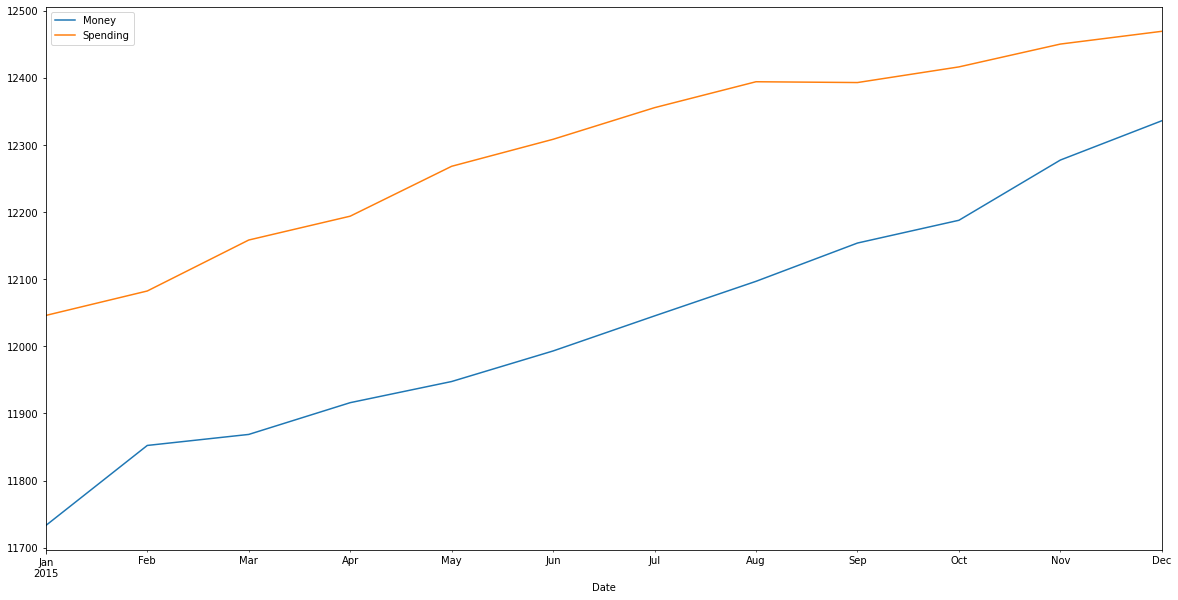

In [47]:
test_range.plot(figsize = (20,10))

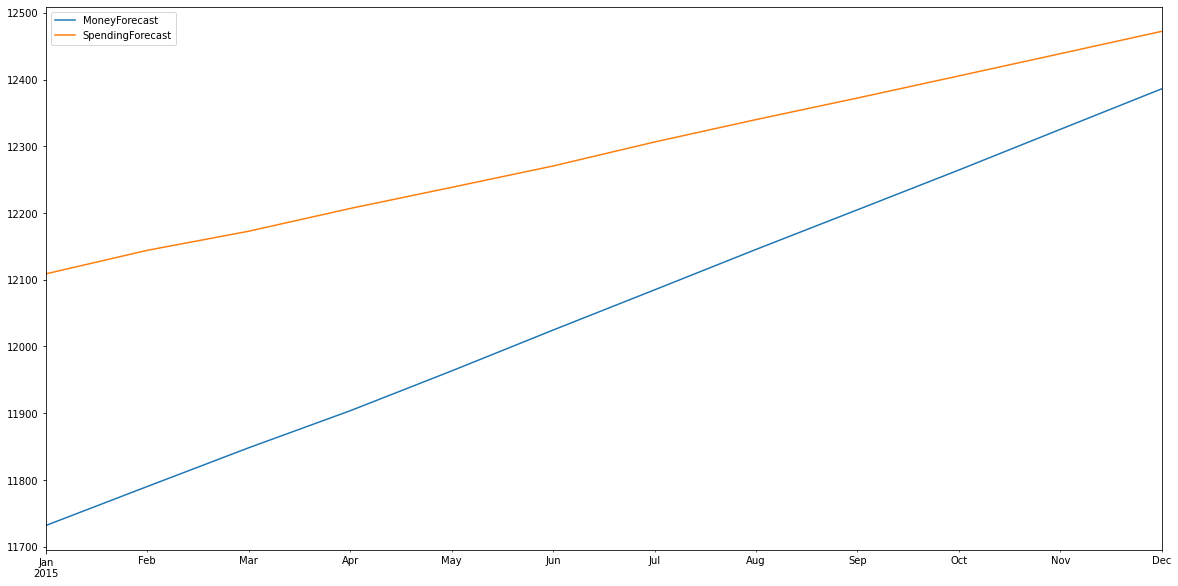

In [48]:
df_forecast[['MoneyForecast','SpendingForecast']].plot(figsize=(20,10))

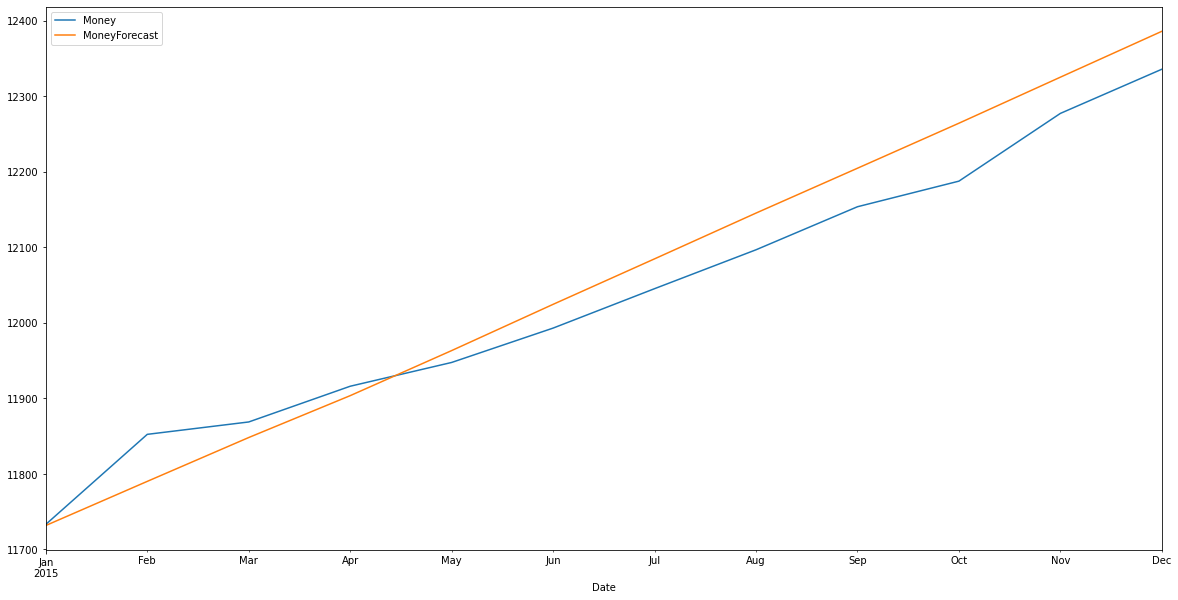

In [49]:
test_range['Money'].plot(legend=True, figsize=(20,10))
df_forecast['MoneyForecast'].plot(legend=True)

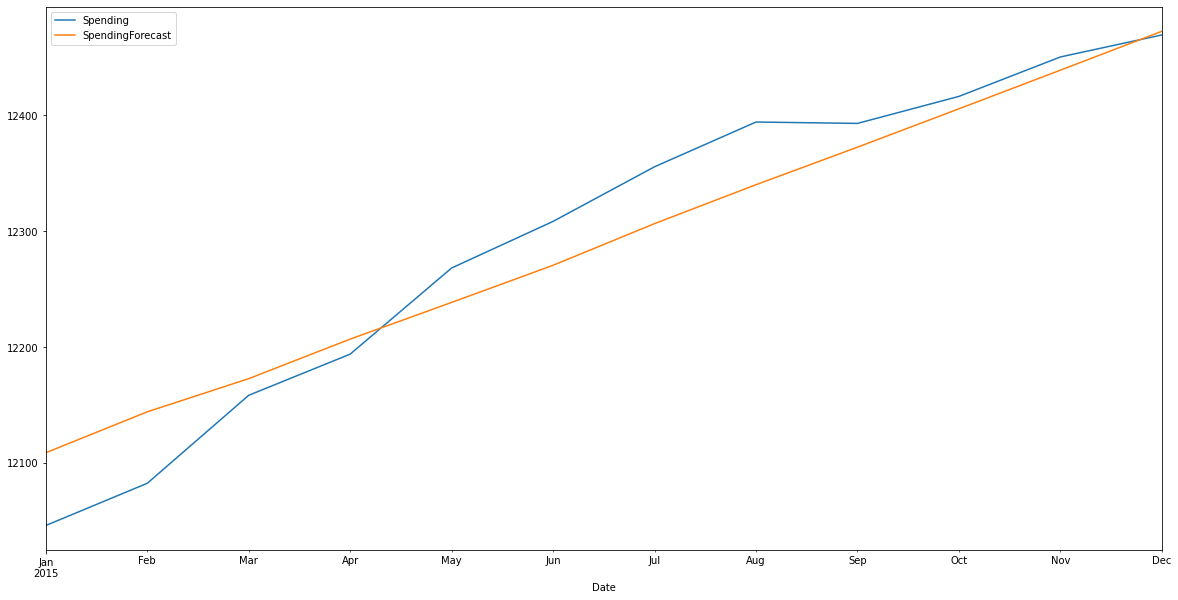

In [50]:
test_range['Spending'].plot(legend=True, figsize=(20,10))
df_forecast['SpendingForecast'].plot(legend=True)

In [51]:
rmse(test_range['Money'], df_forecast['MoneyForecast'])

43.71049653558893

In [52]:
test_range['Money'].mean()

12034.008333333333

In [53]:
rmse(test_range['Spending'], df_forecast['SpendingForecast'])

37.001175169408285

In [54]:
test_range['Spending'].mean()

12294.533333333333